In [2]:
import psycopg2
import time
import sys

In [4]:
# Reset database 
conn = psycopg2.connect(database="tcount", user="postgres")
cur = conn.cursor()

sql = "delete from Tweetwordcount ;" 
cur.execute(sql)
conn.commit()
conn.close()

In [104]:
conn = psycopg2.connect(database="tcount", user="postgres")
cur = conn.cursor()

sql = "select count(*) from Tweetwordcount ;" 
cur.execute(sql)
print cur.fetchall()
conn.commit()
conn.close()

[(35646L,)]


In [166]:
conn = psycopg2.connect(database="tcount", user="postgres")
cur = conn.cursor()

word = 'andreasoto'
sql = "SELECT * FROM Tweetwordcount WHERE word='%s';" %(word)
cur.execute(sql)
test = cur.fetchall()
conn.commit()
conn.close()

In [167]:
len(test)

0

---
# Serving Scripts

## 1) finalresults.py

This script gets a word as an argument and returns the total number of word occurrences in the stream. This script can also be used to query all the word counts, order them alphabetically, and report the first N word counts. The default N is 25, but this number can be sent as an input.

**USAGE**

To get the number of occurances of a single word:  
> `python finalresults.py hello`
    
Get all the word counts, sorted alphabetically, one per line:
> `python finalresults.py`
    
The default is to show only the first 25 words. To increase the number of words shown, send the number of records to show as an input:
> `python finalresults.py 2000`

In [171]:
%%writefile analysis/finalresults.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import psycopg2
import time
import sys
   
def get_wordCount(word, show=25):
    # Get count for the input word or all word counts. 
    # The output is restricted to the 'show' value.
    
    # Connect to database
    conn = psycopg2.connect(database="tcount", user="postgres")
    cur = conn.cursor()
    
    # Get total words counted in tweets
    sql = "SELECT count(*) FROM Tweetwordcount ;" 
    cur.execute(sql)
    total_words = cur.fetchall()
    conn.commit()
    
    # Get count for word or all words (depending on input)
    if word == None:
        sql = "SELECT * FROM Tweetwordcount ORDER BY word ASC LIMIT %d;"%(min(show,total_words[0][0]))        
    else:
        sql = "SELECT * FROM Tweetwordcount WHERE word='%s';" %(word)
    
    cur.execute(sql)
    result = cur.fetchall()
    conn.commit()
    conn.close()
    
    # Print results
    if word == None:
        print 'First %d word-counts (out of %d words):\n'%(min(show,total_words[0][0]),total_words[0][0])
        print "%12s  %s"%('Word','Count')
        for w,c in result:
            print "%12s  %d"%(w,c)
    else:
        print "Number of occurences of '%s':  %d"%(result[0][0], result[0][1]), "\t@", time.ctime(time.time())

# ===================================================================================
if __name__ == '__main__':
    '''
    To get the number of occurances of single word:
       python finalresults.py hello
    
    Get all the word counts, sorted alphabetically, one per line:
       python finalresults.py
    
    The default is to show only the first 25 words. 
    To increase the number of words shown, send any number as an input:
       python finalresults.py 2000
    '''    
    
    numToShow = 25
    word = None
    # Get input word if any
    if len(sys.argv) > 1:
        # Get target word
        if sys.argv[1].isdigit():
            numToShow = int(sys.argv[1])
        else:
            word = sys.argv[1]
    
    get_wordCount(word, numToShow)

Overwriting analysis/finalresults.py


### Sample Output of finalresults.py

In [158]:
!python analysis/finalresults.py 10

First 10 word-counts (out of 777 words):

        Word  Count
           a  63
        able  2
       about  7
   according  1
     account  2
    actually  3
     address  3
       adele  1
      adidas  2
       after  1


In [9]:
!python analysis/finalresults.py the

Number of occurences of 'the':  4585 	@ Thu Dec  3 03:37:58 2015


In [105]:
!python analysis/finalresults.py the

Number of occurences of 'the':  60769 	@ Thu Dec  3 05:16:51 2015


In [106]:
!python analysis/finalresults.py the

Number of occurences of 'the':  60792 	@ Thu Dec  3 05:16:54 2015


In [16]:
!python analysis/finalresults.py 10

First 10 word-counts (out of 10059 words):

        Word  Count
           a  4168
      aaaaah  2
      aaaand  2
       aampa  2
       aampp  2
       aaood  2
       aaron  2
      aatuit  2
          ab  12
     abandon  2


## 2) histogram.py

This script gets two integers k1,k2 and returns all the words that their total number of occurrences in the stream is more or equal than k1 and less or equal than k2. 

**USAGE**

To get all the words with a frequency between 100 and 400:  
> `python histogram.py 100 400`

In [20]:
%%writefile analysis/histogram.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import psycopg2
import time
import sys
   
def histogram(min_frq, max_frq, show):
        
    # Connect to database
    conn = psycopg2.connect(database="tcount", user="postgres")
    cur = conn.cursor()
    
    # Get total words with count within interval
    sql = "SELECT count(*) FROM Tweetwordcount WHERE count >= %d and count <= %d;"%(min_frq, max_frq)
    cur.execute(sql)
    total_words = cur.fetchall()
    conn.commit()
    
    # Get words with count within interval
    sql = "SELECT * FROM Tweetwordcount WHERE "
    sql += "count >= %d and count <= %d ORDER BY count ASC LIMIT %d;"%(min_frq, max_frq, show)
    
    cur.execute(sql)
    result = cur.fetchall()
    conn.commit()
    conn.close()
    
    # Print results
    print 'Reporting %d words (out of %d words):\n'%(min(show,total_words[0][0]),total_words[0][0])
    print "%12s  %s"%('Word','Count')
    for w,c in result:
        print "%12s  %d"%(w,c)

# ===================================================================================
if __name__ == '__main__':
    '''
    Get all the words with count between MIN and MAX value provided:
       python histogram.py 100 400
    
    The default is to show only the first 25 words. 
    To increase the number of words shown, send the number to show as a 3rd parameter:
       python histogram.py 100 400 50
    '''    
    
    numToShow = 25
    if len(sys.argv) < 3:
        print "Few inputs - MIN and MAX values for count interval are requiered"
    else:
        minVal = int(sys.argv[1])
        maxVal = int(sys.argv[2])
        if len(sys.argv) == 4:
            numToShow = int(sys.argv[3])
        if minVal > maxVal:
            print "min value provided is greater than max value. Values will be switched."
    
    histogram(minVal, maxVal, numToShow)

Overwriting analysis/histogram.py


### Sample Output of histogram.py

In [22]:
!python analysis/histogram.py 1000 1100

Reporting 5 words (out of 5 words):

        Word  Count
         our  1040
         her  1047
      weeknd  1070
       would  1072
        back  1087


## 3) Top 20-words by count

This script finds the top-20 words by count. It prints the words out and also creates a bar-chart called `Plot.png`. 

**USAGE**

To get the top-20 words by count:  
> `python top20.py`

In [98]:
%%writefile analysis/top20.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import psycopg2
import numpy as np

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
    
def bar_plot(names, values):    
    
    n = np.arange(len(values))
    plt.figure(figsize=(14,7))
    plt.title('Top-20 Words by Count\n', size=18)
    plt.ylabel("Occurrences (count)", size=14)
    plt.bar(n, values, color='#89C6DA')
    plt.xticks(n+0.5, names, rotation=0, size=12)
    
    plt.savefig('analysis/plot.png', format='png')
    
def top20():
        
    # Connect to database
    conn = psycopg2.connect(database="tcount", user="postgres")
    cur = conn.cursor()
    
    # Get total word count
    sql = "SELECT count(count) FROM Tweetwordcount;"
    cur.execute(sql)
    total_count = cur.fetchall()
    conn.commit()
    
    # Get top-20
    sql = "SELECT * FROM Tweetwordcount ORDER BY count DESC LIMIT 20;"
    
    cur.execute(sql)
    result = cur.fetchall()
    conn.commit()
    conn.close()
    
    # Print results
    print 'Top-20'
    print "%s %8s  %s"%('ID','Word','Count')
    rank = 1
    words = []
    counts = []
    for w,c in result:
        print "%2d  %8s  %d"%(rank,w,c)
        words.append(w)
        counts.append(c)
        rank += 1

    bar_plot(words, counts)

# ===================================================================================
if __name__ == '__main__':
    '''
    Get top-20 words by count
       python top20.py
    '''    
    top20()

Overwriting analysis/top20.py


### Sample Output

In [99]:
!python analysis/top20.py

Top-20
ID     Word  Count
 1       the  58806
 2         i  49336
 3         a  39145
 4       you  38929
 5        to  35237
 6        is  23737
 7       and  20060
 8        in  19264
 9        of  19020
10        my  18020
11      this  16296
12       for  16161
13        me  15780
14        im  14802
15        so  12657
16      when  12378
17        it  11732
18        on  11549
19      with  11066
20      just  10622


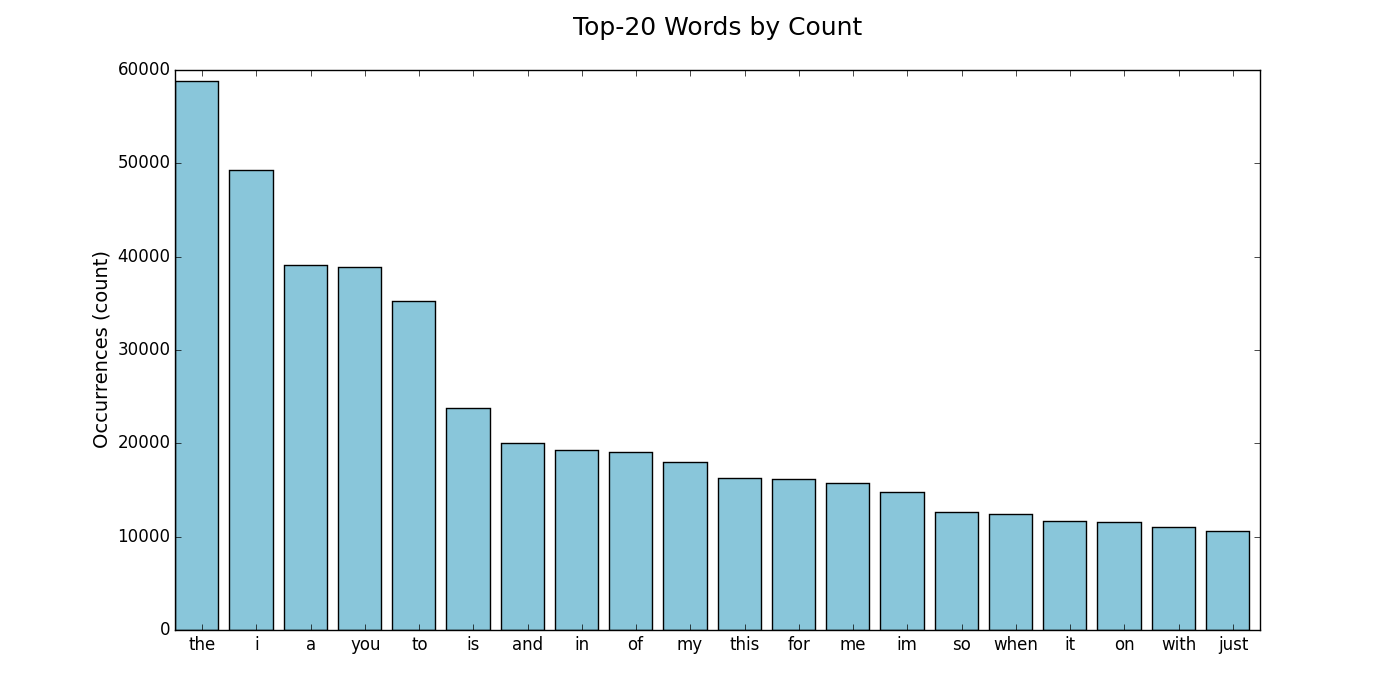

In [101]:
from IPython.display import Image
Image(filename='analysis/plot.png')

---
# Spout: tweet.py

In [2]:
%%writefile EX2Tweetwordcount/src/spouts/tweets.py
from __future__ import absolute_import, print_function, unicode_literals
#TEST THIS
import itertools, time
import tweepy, copy 
import Queue, threading

from streamparse.spout import Spout

################################################################################
# Twitter credentials
################################################################################
twitter_credentials = {
}

def auth_get(auth_key):
    if auth_key in twitter_credentials:
        return twitter_credentials[auth_key]
    return None

################################################################################
# Class to listen and act on the incoming tweets
################################################################################
class TweetStreamListener(tweepy.StreamListener):

    def __init__(self, listener):
        self.listener = listener
        super(self.__class__, self).__init__(listener.tweepy_api())

    def on_status(self, status):
        self.listener.queue().put(status.text, timeout = 0.01)
        return True
  
    def on_error(self, status_code):
        return True # keep stream alive
  
    def on_limit(self, track):
        return True # keep stream alive

class Tweets(Spout):

    def initialize(self, stormconf, context):
        self._queue = Queue.Queue(maxsize = 100)

        consumer_key = auth_get("consumer_key") 
        consumer_secret = auth_get("consumer_secret") 
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

        if auth_get("access_token") and auth_get("access_token_secret"):
            access_token = auth_get("access_token")
            access_token_secret = auth_get("access_token_secret")
            auth.set_access_token(access_token, access_token_secret)

        self._tweepy_api = tweepy.API(auth)

        # Create the listener for twitter stream
        listener = TweetStreamListener(self)

        # Create the stream and listen for english tweets
        stream = tweepy.Stream(auth, listener, timeout=None)
        stream.filter(languages=["en"], track=["a", "the", "i", "you", "u"], async=True)

    def queue(self):
        return self._queue

    def tweepy_api(self):
        return self._tweepy_api

    def next_tuple(self):
        try:
            tweet = self.queue().get(timeout = 0.1) 
            if tweet:
                self.queue().task_done()
                self.emit([tweet])
 
        except Queue.Empty:
            self.log("Empty queue exception")
            time.sleep(0.1) 

    def ack(self, tup_id):
        pass  # if a tuple is processed properly, do nothing

    def fail(self, tup_id):
        pass  # if a tuple fails to process, do nothing

Overwriting EX2Tweetwordcount/src/spouts/tweets.py


# Bolt: parse.py

In [157]:
%%writefile EX2Tweetwordcount/src/bolts/parse.py 
from __future__ import absolute_import, print_function, unicode_literals

import re
from streamparse.bolt import Bolt

################################################################################
# Function to check if the string contains only ascii chars
################################################################################
def ascii_string(s):
    return all(ord(c) < 128 for c in s)

class ParseTweet(Bolt):

    def process(self, tup):
        tweet = tup.values[0]  # extract the tweet

        # Split the tweet into words
        words = tweet.split()

        # Filter out the hash tags, RT, @ and urls
        valid_words = []
        for word in words:

            # Filter the hash tags
            if word.startswith("#"): continue

            # Filter the user mentions
            if word.startswith("@"): continue

            # Filter out retweet tags
            if word.startswith("RT"): continue

            # Filter out the urls
            if word.startswith("http"): continue

            # Strip leading and lagging punctuations
            aword = word.strip("\"?><,'.:;)")
            # Clean other charactes from string 
            aword = aword.lower()
            # Basic word cleaning
            aword = re.sub("'","",aword)
            aword = re.sub("/","", aword)
            aword = re.sub("\)","", aword)
            aword = re.sub("\(","", aword)
            aword = re.sub("[0-9!@#$%^&*-_+=~{}|:;<>?,.]","", aword)
            aword = aword.replace("\\","")

            # now check if the word contains only ascii
            if len(aword) > 0 and ascii_string(word):
                valid_words.append([aword])

        if not valid_words: return

        # Emit all the words
        self.emit_many(valid_words)

        # tuple acknowledgement is handled automatically

Overwriting src/bolts/parse.py


# Bolt: wordcount.py

In [1]:
%%writefile EX2Tweetwordcount/src/bolts/wordcount.py
from __future__ import absolute_import, print_function, unicode_literals

from collections import Counter
from redis import StrictRedis
from streamparse.bolt import Bolt

import psycopg2
import time

class WordCounter(Bolt):

    def initialize(self, conf, ctx):
        self.counts = Counter()
        self.redis = StrictRedis()

    def process(self, tup):
        word = tup.values[0]

        # Write codes to increment the word count in Postgres
        # Use psycopg to interact with Postgres
        # Database name: Tcount 
        # Table name: Tweetwordcount 
        
        # Connect to database
        conn = psycopg2.connect(database="tcount", user="postgres")
        cur = conn.cursor()
        
        # Increment the local count
        self.counts[word] += 1
        
        if self.counts[word] == 1:
            # New word > INSERT INTO
            sql = "INSERT INTO Tweetwordcount (word,count) VALUES ('%s', %d);" %(unicode(word), self.counts[word])
        else:
            # Update word count > UPDATE
            sql = "UPDATE Tweetwordcount SET count=%d WHERE word='%s';" %(self.counts[word], unicode(word))

        cur.execute(sql)
        conn.commit()
        #self.emit([word, self.counts[word]])

        # Log the count - just to see the topology running
        #self.log('%s: %d' % (word, self.counts[word]))

Overwriting EX2Tweetwordcount/src/bolts/wordcount.py
